# Capstone - Respiratory Data Analysis - Deep Learning approach

This notebook provides implementation and evaluation of different Deep Neural Network architectures evaluation for Respiratory Data Analysis multi-class classification.

In [1]:
dataset_export_path='../dataset/Respiratory_dataset/respiratory-sound-database-export/export/'
data_path=dataset_export_path+"respiratoryDataAugmented_v1.2"

In [2]:
import findspark
findspark.init()
import pyspark

In [3]:
sc = pyspark.SparkContext(appName="RespiratoryDataAnalysisModelDL_1.3",
                         master="local[2]").getOrCreate()
sc

<SparkContext master=local[2] appName=RespiratoryDataAnalysisModelDL_1.3>

In [4]:
from pyspark import SQLContext
sql_c = SQLContext(sc)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
diagnosisList = ['COPD','Healthy','URTI','Bronchiectasis','Bronchiolitis','Pneumonia','LRTI','Asthma']

In [7]:
from pyspark.sql import DataFrameReader
data_df = sql_c.read.json(path=data_path)

In [8]:
data_df.dtypes

[('_1', 'string'),
 ('_2', 'bigint'),
 ('_3', 'double'),
 ('_4', 'double'),
 ('_5', 'bigint'),
 ('_6', 'array<array<double>>')]

In [9]:
data_df.repartition(2)

DataFrame[_1: string, _2: bigint, _3: double, _4: double, _5: bigint, _6: array<array<double>>]

In [10]:
data_df = data_df.withColumnRenamed('_1', 'file_name')\
        .withColumnRenamed('_2', 'sampleId')\
        .withColumnRenamed('_3', 'patientId')\
        .withColumnRenamed('_4', 'diagIndex')\
        .withColumnRenamed('_5', 'recSource')\
        .withColumnRenamed('_6', 'mfcc')



In [11]:
data_df = data_df.withColumn('label', data_df["diagIndex"].cast("int"))

In [12]:
from pyspark.sql import functions
data_df = data_df.withColumn('feature',functions.flatten(data_df.mfcc))

In [13]:
data_df.show(1)

+--------------------+--------+---------+---------+---------+--------------------+-----+--------------------+
|           file_name|sampleId|patientId|diagIndex|recSource|                mfcc|label|             feature|
+--------------------+--------+---------+---------+---------+--------------------+-----+--------------------+
|200_2p2_Ar_mc_AKG...|       6|    200.0|      0.0|        2|[[-198.7150412270...|    0|[-198.71504122702...|
+--------------------+--------+---------+---------+---------+--------------------+-----+--------------------+
only showing top 1 row



In [14]:
data_df.dtypes

[('file_name', 'string'),
 ('sampleId', 'bigint'),
 ('patientId', 'double'),
 ('diagIndex', 'double'),
 ('recSource', 'bigint'),
 ('mfcc', 'array<array<double>>'),
 ('label', 'int'),
 ('feature', 'array<double>')]

In [15]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import Normalizer

from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

data_df = data_df.withColumn("features_unnorm", to_vector("feature"))
data_df = data_df.drop("features")

In [16]:
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark import keyword_only 

class ArrayVectorTransformer(Transformer, HasInputCol, HasOutputCol):
 
   @keyword_only
   def __init__(self, inputCol=None, outputCol=None):
       super(ArrayVectorTransformer, self).__init__()
       kwargs = self._input_kwargs
       self.setParams(**kwargs)
 
   @keyword_only
   def setParams(self, inputCol=None, outputCol=None):
       kwargs = self._input_kwargs
       return self._set(**kwargs)
 
   def _transform(self, dataset):
       assembliedDenseVector = udf(lambda a: Vectors.dense(a), VectorUDT())(dataset[self.getInputCol()])
       return dataset.withColumn(self.getOutputCol(), assembliedDenseVector).drop(self.getInputCol())

In [17]:
from pyspark.ml.linalg import Vectors

vassembler = ArrayVectorTransformer(inputCol='feature', 
                                     outputCol='features_unnorm')


In [18]:
data_df.dtypes

[('file_name', 'string'),
 ('sampleId', 'bigint'),
 ('patientId', 'double'),
 ('diagIndex', 'double'),
 ('recSource', 'bigint'),
 ('mfcc', 'array<array<double>>'),
 ('label', 'int'),
 ('feature', 'array<double>')]

In [19]:
encoder = OneHotEncoder(inputCol='label', outputCol='labelCat')
encoder.setDropLast(False)

OneHotEncoder_f171cff22367

In [20]:
normalizer = Normalizer(p=1.0, inputCol="features_unnorm", outputCol="features")

In [21]:
from pyspark.ml import Pipeline
feature_pipeline = Pipeline(stages = [encoder, vassembler, normalizer])

In [22]:
feature_model = feature_pipeline.fit(data_df)
data_df = feature_model.transform(data_df)

In [24]:
data_df.dtypes

[('file_name', 'string'),
 ('sampleId', 'bigint'),
 ('patientId', 'double'),
 ('diagIndex', 'double'),
 ('recSource', 'bigint'),
 ('mfcc', 'array<array<double>>'),
 ('label', 'int'),
 ('labelCat', 'vector'),
 ('features_unnorm', 'vector'),
 ('features', 'vector')]

In [25]:
data_df.select('labelCat').dtypes

[('labelCat', 'vector')]

In [26]:
data_df.select('labelCat').show(1)

+-------------+
|     labelCat|
+-------------+
|(8,[0],[1.0])|
+-------------+
only showing top 1 row



In [27]:
data_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 1069|
|    6| 1003|
|    3| 1031|
|    5| 1073|
|    4| 1025|
|    7| 1001|
|    2| 1045|
|    0|  999|
+-----+-----+



In [28]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
train = data_df.filter(data_df.recSource=='2')
test = data_df.filter(data_df.recSource=='1')
train, val = train.randomSplit([0.8, 0.2], seed=23456)

# Deep Learning models 

### Models are implemented with Keras/Tensorflow

## Classification using DFF-NN

In [30]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.utils import np_utils
from keras.utils import to_categorical
from sklearn import metrics 
import tensorflow as tf

/Users/famillenassivet/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [32]:
labels_train = np.asarray(train.select('labelCat').rdd.map(lambda x : x.labelCat).collect())
features_train = np.asarray(train.select('features').rdd.map(lambda x : x.features).collect())

labels_val = np.asarray(val.select('labelCat').rdd.map(lambda x : x.labelCat).collect())
features_val = np.asarray(val.select('features').rdd.map(lambda x : x.features).collect())

labels_test = np.asarray(test.select('labelCat').rdd.map(lambda x : x.labelCat).collect())
features_test = np.asarray(test.select('features').rdd.map(lambda x : x.features).collect())


In [33]:
labels_test[0], features_test[0]

(array([1., 0., 0., 0., 0., 0., 0., 0.]),
 array([-1.46822868e-01, -1.45204560e-01, -1.46229407e-01, ...,
         3.02908815e-04,  4.31771525e-05,  3.75278936e-04]))

In [34]:
X_train = features_train
X_val = features_val
X_test = features_test
y_train = labels_train
y_val = labels_val
y_test = labels_test

In [35]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6313, 5120), (6313, 8), (446, 5120), (446, 8))

In [36]:
num_labels = y_train.shape[1]
filter_size = 2

In [37]:
# build MLP model
model = Sequential()
model._name = "DFF-NN_dense_2048_Drop0.2_dense_512_drop0.5"

model.add(Dense(2048, input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [38]:
model.compile(loss=[tf.keras.losses.CategoricalCrossentropy()], 
              metrics=[tf.keras.metrics.CategoricalAccuracy()], 
              optimizer='adam')

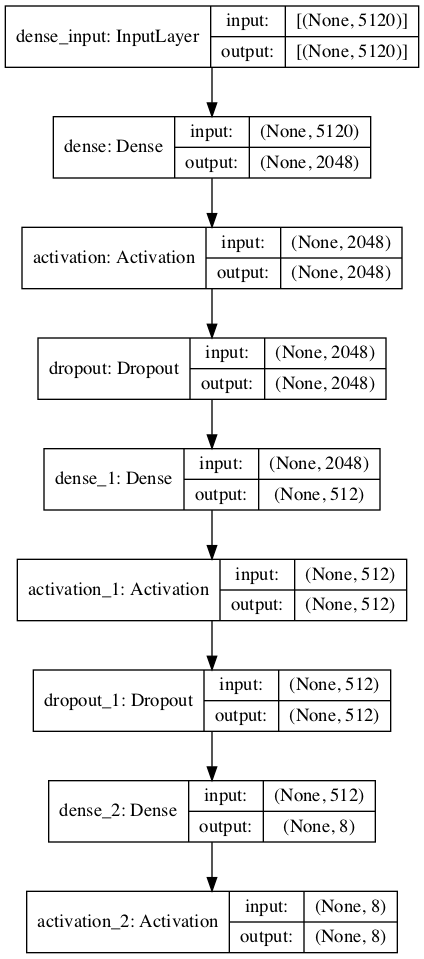

In [39]:
from tensorflow.keras import utils
utils.plot_model(model, 'BNA_Capstone_DFF-NN_model.png', show_shapes=True)

### Display the NN graph

In [40]:
model.summary()

Model: "DFF-NN_dense_2048_Drop0.2_dense_512_drop0.5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              10487808  
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)        

In [41]:
callbacks = [
  # Interrupt training if `val_loss` stops improving for over 2 epochs
  tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')]

In [42]:
fnn_history = model.fit(X_train, y_train, batch_size=32, epochs=30, callbacks=callbacks, validation_data=(X_val, y_val))

Train on 6313 samples, validate on 1487 samples
Epoch 1/30
6313/6313 [==============================] - 12s 2ms/sample - loss: 1.3476 - categorical_accuracy: 0.4969 - val_loss: 0.7540 - val_categorical_accuracy: 0.7492
Epoch 2/30
6313/6313 [==============================] - 12s 2ms/sample - loss: 0.6192 - categorical_accuracy: 0.7749 - val_loss: 0.4529 - val_categorical_accuracy: 0.8379
Epoch 3/30
6313/6313 [==============================] - 12s 2ms/sample - loss: 0.3927 - categorical_accuracy: 0.8636 - val_loss: 0.3290 - val_categorical_accuracy: 0.8843
Epoch 4/30
6313/6313 [==============================] - 12s 2ms/sample - loss: 0.2561 - categorical_accuracy: 0.9195 - val_loss: 0.2621 - val_categorical_accuracy: 0.9072
Epoch 5/30
6313/6313 [==============================] - 12s 2ms/sample - loss: 0.1658 - categorical_accuracy: 0.9536 - val_loss: 0.1235 - val_categorical_accuracy: 0.9623
Epoch 6/30
6313/6313 [==============================] - 12s 2ms/sample - loss: 0.0976 - categoric

In [43]:
train_loss, train_acc = model.evaluate(X_train, y_train)

print('Train accuracy:', train_acc)
print('Train loss:', train_loss)

6313/6313 [==============================] - 2s 377us/sample - loss: 0.0017 - categorical_accuracy: 0.9995
Train accuracy: 0.9995248
Train loss: 0.0017158333996735776


In [44]:
val_loss, val_acc = model.evaluate(X_val, y_val)

print('Val accuracy:', val_acc)
print('Val loss:', val_loss)

1487/1487 [==============================] - 1s 391us/sample - loss: 0.0504 - categorical_accuracy: 0.9886
Val accuracy: 0.9885676
Val loss: 0.05044847841690774


In [45]:
predictions = model.predict(X_test)

In [46]:
def plot_model_perfos(nn_modelname, nn_history):
    #import matplotlib as plt
    
    accuracy = nn_history.history['categorical_accuracy']
    val_accuracy = nn_history.history['val_categorical_accuracy']
    loss = nn_history.history['loss']
    val_loss = nn_history.history['val_loss']
    epochs = range(len(accuracy))
    
    fig = plt.figure(figsize=(14,6))
    plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,right = 0.9, top = 0.9, wspace = 0.5, hspace = 1)
    fig.suptitle("Model performances (accuracy & loss) - " + nn_modelname)
    
    ax1 = plt.subplot(121)
    
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    ax1.set_title('Training and validation accuracy')
    plt.legend()
    #plt.figure()

    ax2 = plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    ax2.set_title('Training and validation loss')
    plt.legend()
    plt.show()

In [150]:
def plot_confusion_matrix(cmat, 
                          classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix cmat.
    Normalization can be applied by setting `normalize=True`.
    """
    from matplotlib.pyplot import cm

    fig = plt.figure(figsize=(14,6))
    plt.gcf().subplots_adjust( top = 0.9, wspace = 0.4, hspace = 1)
    fig.suptitle(title)
    
    normalized_cm_title = 'Normalized confusion matrix'
    cm_title = 'Confusion matrix'

    normalized_cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]
    cmat = cmat.astype('int')
    
    def plot_cm(title, ax, confmat, normalize):
        im = ax.imshow(confmat, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(confmat.shape[1]),
               yticks=np.arange(confmat.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'

        thresh = confmat.max() / 2.
        for i in range(confmat.shape[0]):
            for j in range(confmat.shape[1]):
                ax.text(j, i, format(confmat[i, j], fmt),
                        ha="center", va="center",
                        color="white" if confmat[i, j] > thresh else "black")

        return ax
    
    fig.tight_layout()
    ax1 = plt.subplot(121)
    plot_cm(normalized_cm_title, ax1, normalized_cmat, normalize=True)
    ax2 = plt.subplot(122)
    plot_cm(cm_title, ax2, cmat, normalize=False)

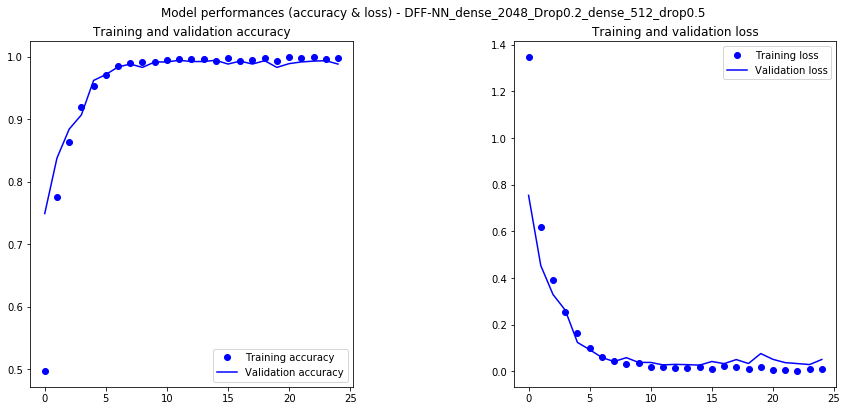

In [126]:
plot_model_perfos(model._name, fnn_history)

In [48]:
predictions[0]

array([9.9996066e-01, 1.7170678e-05, 1.6270720e-05, 5.9905124e-06,
       3.5355786e-08, 4.4344311e-12, 5.0219585e-11, 1.2048595e-13],
      dtype=float32)

In [49]:
y_test[0]

array([1., 0., 0., 0., 0., 0., 0., 0.])

In [50]:
y_test.shape, predictions.shape

((446, 8), (446, 8))

In [51]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

446/446 [==============================] - 0s 430us/sample - loss: 1.3145 - categorical_accuracy: 0.7668
Test accuracy: 0.76681614
Test loss: 1.314534241308546


In [52]:
from sklearn.metrics import classification_report
report = classification_report(y_test.argmax(axis=1), 
                               predictions.argmax(axis=1),
                              target_names=diagnosisList)
print(report)

                precision    recall  f1-score   support

          COPD       0.96      0.86      0.91       199
       Healthy       0.89      0.46      0.61        69
          URTI       0.50      0.76      0.60        45
Bronchiectasis       0.77      0.97      0.86        31
 Bronchiolitis       0.35      0.52      0.42        25
     Pneumonia       0.71      0.82      0.76        73
          LRTI       0.00      0.00      0.00         3
        Asthma       1.00      1.00      1.00         1

   avg / total       0.81      0.77      0.77       446



In [53]:
conf_mat = tf.math.confusion_matrix(labels=y_test.argmax(axis=1), 
                         predictions=predictions.argmax(axis=1))

W0525 19:45:07.754711 140735699682176 deprecation.py:323] From /Users/famillenassivet/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/confusion_matrix.py:194: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0525 19:45:07.755885 140735699682176 deprecation.py:323] From /Users/famillenassivet/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/confusion_matrix.py:195: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


In [54]:
conf_mat.numpy().tolist()

[[172, 1, 3, 8, 2, 13, 0, 0],
 [2, 32, 19, 1, 11, 4, 0, 0],
 [0, 1, 34, 0, 7, 3, 0, 0],
 [1, 0, 0, 30, 0, 0, 0, 0],
 [1, 1, 6, 0, 13, 4, 0, 0],
 [4, 0, 4, 0, 4, 60, 1, 0],
 [0, 1, 2, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1]]

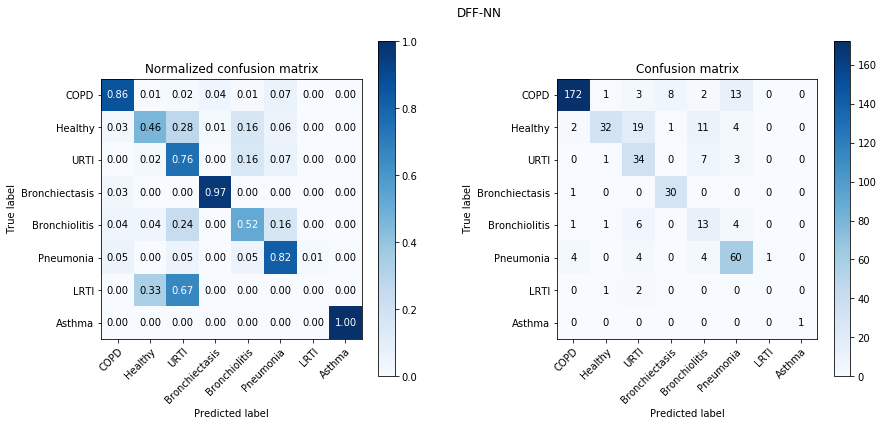

In [151]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(conf_mat.numpy(), 
                      classes=diagnosisList,
                      title='DFF-NN')


In [152]:
plt.close()

## CNN

In [153]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import LeakyReLU


In [154]:
y_train = np.asarray(train.select('labelCat').rdd.map(lambda x : x.labelCat).collect())
mfcc_train = np.asarray(train.select('mfcc').rdd.map(lambda x : x.mfcc).collect())

y_val = np.asarray(val.select('labelCat').rdd.map(lambda x : x.labelCat).collect())
mfcc_val = np.asarray(val.select('mfcc').rdd.map(lambda x : x.mfcc).collect())

y_test = np.asarray(test.select('labelCat').rdd.map(lambda x : x.labelCat).collect())
mfcc_test = np.asarray(test.select('mfcc').rdd.map(lambda x : x.mfcc).collect())



In [155]:
mfcc_train.shape

(6313, 128, 40)

Since convolution will be applied, the MFCC cells have to be reshaped with one additional dimension

In [156]:
mfcc_train = mfcc_train.reshape(-1,128,40,1)
mfcc_val = mfcc_val.reshape(-1,128,40,1)
mfcc_test = mfcc_test.reshape(-1,128,40,1)


In [157]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [158]:
cnn_model = Sequential()
cnn_model._name = "CNN-model"

cnn_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(128,40,1),padding='same'))
cnn_model.add(MaxPooling2D((2, 2),padding='same'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))                 
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))                  
cnn_model.add(Dense(num_labels, activation='softmax'))


In [159]:
cnn_model.summary()

Model: "CNN-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 40, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 20, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 10, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 10, 128)       73

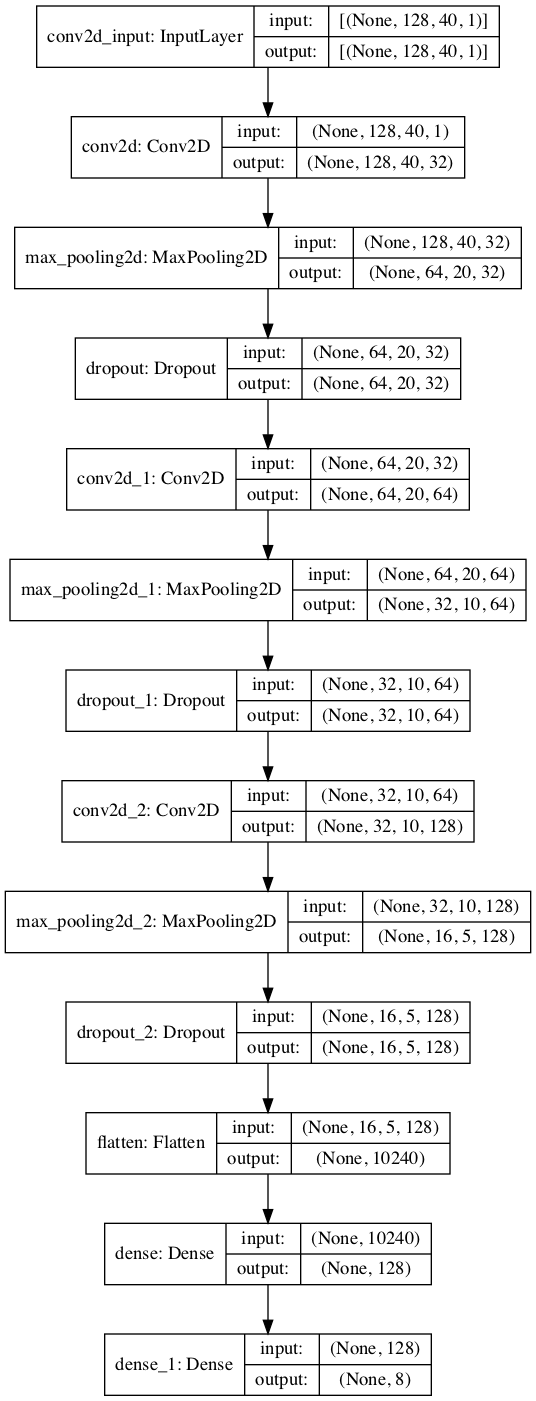

In [160]:
from tensorflow.keras import utils
utils.plot_model(cnn_model, 'BNA_Capstone_CNN-model.png', show_shapes=True)

In [161]:
cnn_model.compile(loss=[tf.keras.losses.CategoricalCrossentropy()], 
              metrics=[tf.keras.metrics.CategoricalAccuracy()], 
              optimizer='adam')

In [162]:
cnn_history = cnn_model.fit(mfcc_train, y_train, batch_size=64, epochs=10, callbacks=callbacks, validation_data=(mfcc_val, y_val))

Train on 6313 samples, validate on 1487 samples
Epoch 1/10
6313/6313 [==============================] - 32s 5ms/sample - loss: 2.8319 - categorical_accuracy: 0.3292 - val_loss: 1.0844 - val_categorical_accuracy: 0.6066
Epoch 2/10
6313/6313 [==============================] - 31s 5ms/sample - loss: 0.8164 - categorical_accuracy: 0.7068 - val_loss: 0.5683 - val_categorical_accuracy: 0.7909
Epoch 3/10
6313/6313 [==============================] - 31s 5ms/sample - loss: 0.5264 - categorical_accuracy: 0.8136 - val_loss: 0.3663 - val_categorical_accuracy: 0.8662
Epoch 4/10
6313/6313 [==============================] - 31s 5ms/sample - loss: 0.3697 - categorical_accuracy: 0.8687 - val_loss: 0.3258 - val_categorical_accuracy: 0.8816
Epoch 5/10
6313/6313 [==============================] - 31s 5ms/sample - loss: 0.2659 - categorical_accuracy: 0.9075 - val_loss: 0.2161 - val_categorical_accuracy: 0.9287
Epoch 6/10
6313/6313 [==============================] - 31s 5ms/sample - loss: 0.2087 - categoric

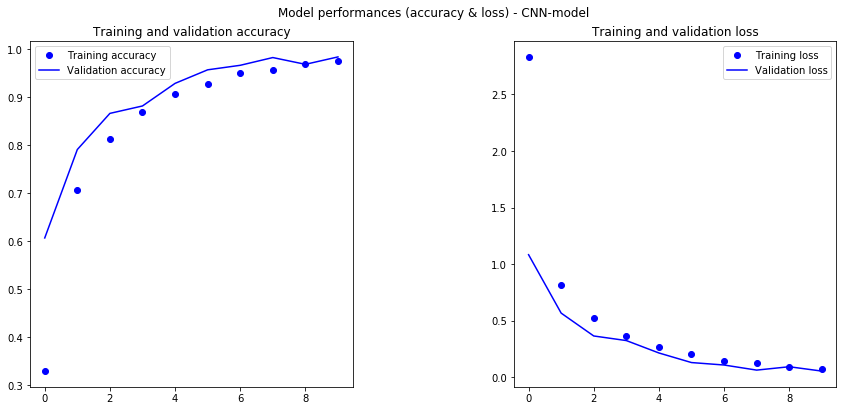

In [163]:
plot_model_perfos(cnn_model._name, cnn_history)

In [164]:
train_loss, train_acc = cnn_model.evaluate(mfcc_train, y_train)

print('Train accuracy:', train_acc)
print('Train loss:', train_loss)

6313/6313 [==============================] - 10s 2ms/sample - loss: 0.0138 - categorical_accuracy: 0.9970
Train accuracy: 0.9969903
Train loss: 0.013776457104079662


In [165]:
val_loss, val_acc = cnn_model.evaluate(mfcc_val, y_val)

print('Val accuracy:', val_acc)
print('Val loss:', val_loss)

1487/1487 [==============================] - 2s 2ms/sample - loss: 0.0560 - categorical_accuracy: 0.9839
Val accuracy: 0.98386014
Val loss: 0.056025752274771315


In [166]:
cnn_predictions = cnn_model.predict(mfcc_test)

In [167]:
test_loss, test_acc = cnn_model.evaluate(mfcc_test, y_test)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

446/446 [==============================] - 1s 2ms/sample - loss: 0.6555 - categorical_accuracy: 0.8386
Test accuracy: 0.83856505
Test loss: 0.6554868194554418


In [168]:
from sklearn.metrics import classification_report
report = classification_report(y_test.argmax(axis=1), 
                               cnn_predictions.argmax(axis=1),
                              target_names=diagnosisList)
print(report)

                precision    recall  f1-score   support

          COPD       0.96      0.91      0.94       199
       Healthy       0.64      0.86      0.73        69
          URTI       0.72      0.64      0.68        45
Bronchiectasis       0.86      1.00      0.93        31
 Bronchiolitis       0.75      0.60      0.67        25
     Pneumonia       0.85      0.77      0.81        73
          LRTI       0.50      0.33      0.40         3
        Asthma       1.00      1.00      1.00         1

   avg / total       0.85      0.84      0.84       446



In [169]:
conf_mat_cnn = tf.math.confusion_matrix(labels=y_test.argmax(axis=1), 
                         predictions=predictions.argmax(axis=1))

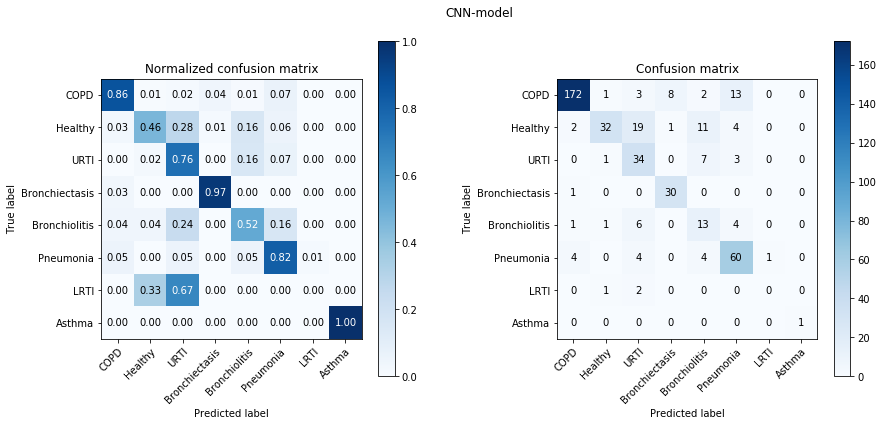

In [170]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(conf_mat_cnn.numpy(), 
                      classes=diagnosisList,
                      title=cnn_model._name)


## CNN Model with LeakyReLU estimator

In [171]:
cnn_model_LR = Sequential()
cnn_model_LR._name = "CNN-model_LeakyReLU"

cnn_model_LR.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(128,40,1),padding='same'))
cnn_model_LR.add(LeakyReLU(alpha=0.1))
cnn_model_LR.add(MaxPooling2D((2, 2),padding='same'))
cnn_model_LR.add(Dropout(0.1))
cnn_model_LR.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
cnn_model_LR.add(LeakyReLU(alpha=0.1))
cnn_model_LR.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model_LR.add(Dropout(0.1))
cnn_model_LR.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
cnn_model_LR.add(LeakyReLU(alpha=0.1))                  
cnn_model_LR.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model_LR.add(Dropout(0.1))
cnn_model_LR.add(Flatten())
cnn_model_LR.add(Dense(128, activation='linear'))
cnn_model_LR.add(LeakyReLU(alpha=0.1))                  
cnn_model_LR.add(Dense(num_labels, activation='softmax'))


In [172]:
cnn_model_LR.summary()

Model: "CNN-model_LeakyReLU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 40, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 40, 32)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 20, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 20, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 20, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 20, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 10, 64)

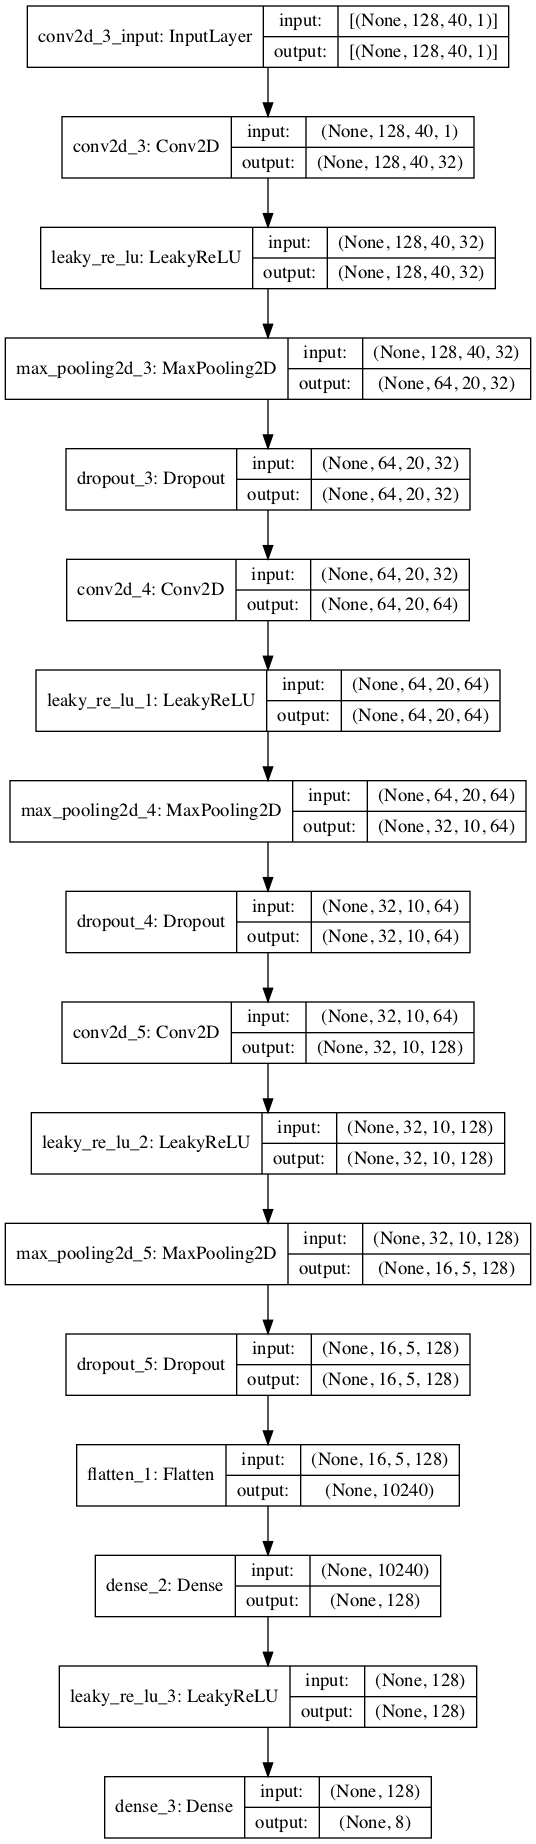

In [173]:
from tensorflow.keras import utils
utils.plot_model(cnn_model_LR, 'BNA_Capstone_CNN-model_LeakyReLU.png', show_shapes=True)

In [174]:
cnn_model_LR.compile(loss=[tf.keras.losses.CategoricalCrossentropy()], 
              metrics=[tf.keras.metrics.CategoricalAccuracy()], 
              optimizer='adam')

In [175]:
cnnlr_history = cnn_model_LR.fit(mfcc_train, y_train, batch_size=128, epochs=15, callbacks=callbacks, validation_data=(mfcc_val, y_val))

Train on 6313 samples, validate on 1487 samples
Epoch 1/15
6313/6313 [==============================] - 33s 5ms/sample - loss: 5.0634 - categorical_accuracy: 0.3141 - val_loss: 1.0740 - val_categorical_accuracy: 0.6174
Epoch 2/15
6313/6313 [==============================] - 41s 7ms/sample - loss: 0.7862 - categorical_accuracy: 0.7207 - val_loss: 0.5778 - val_categorical_accuracy: 0.8063
Epoch 3/15
6313/6313 [==============================] - 33s 5ms/sample - loss: 0.4527 - categorical_accuracy: 0.8448 - val_loss: 0.4183 - val_categorical_accuracy: 0.8265
Epoch 4/15
6313/6313 [==============================] - 32s 5ms/sample - loss: 0.3142 - categorical_accuracy: 0.8896 - val_loss: 0.2310 - val_categorical_accuracy: 0.9328
Epoch 5/15
6313/6313 [==============================] - 32s 5ms/sample - loss: 0.2069 - categorical_accuracy: 0.9328 - val_loss: 0.1861 - val_categorical_accuracy: 0.9422
Epoch 6/15
6313/6313 [==============================] - 32s 5ms/sample - loss: 0.1839 - categoric

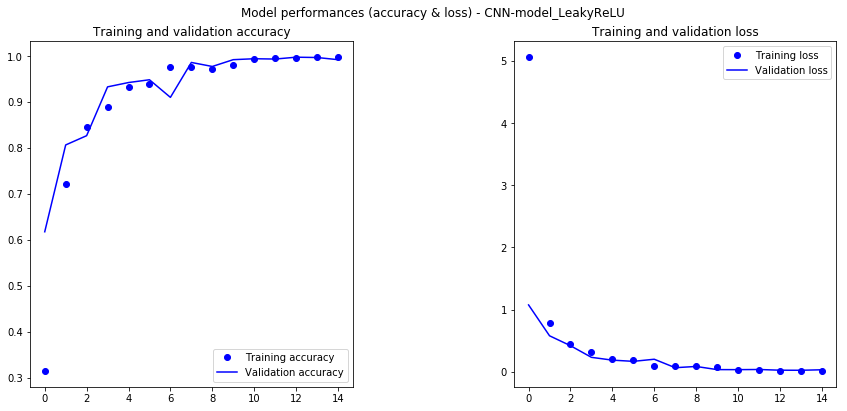

In [176]:
plot_model_perfos(cnn_model_LR._name, cnnlr_history)

In [177]:
train_loss, train_acc = cnn_model_LR.evaluate(mfcc_train, y_train)

print('Train accuracy:', train_acc)
print('Train loss:', train_loss)

6313/6313 [==============================] - 12s 2ms/sample - loss: 0.0073 - categorical_accuracy: 0.9995
Train accuracy: 0.9995248
Train loss: 0.007266115172043953


In [178]:
val_loss, val_acc = cnn_model_LR.evaluate(mfcc_val, y_val)

print('Val accuracy:', val_acc)
print('Val loss:', val_loss)

1487/1487 [==============================] - 3s 2ms/sample - loss: 0.0310 - categorical_accuracy: 0.9919
Val accuracy: 0.99193007
Val loss: 0.031046325304178994


In [179]:
cnnlr_predictions = cnn_model_LR.predict(mfcc_test)

In [180]:
test_loss, test_acc = cnn_model_LR.evaluate(mfcc_test, y_test)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

446/446 [==============================] - 1s 2ms/sample - loss: 0.9982 - categorical_accuracy: 0.7803
Test accuracy: 0.7802691
Test loss: 0.9982255249547317


In [181]:
from sklearn.metrics import classification_report
report = classification_report(y_test.argmax(axis=1), 
                               cnnlr_predictions.argmax(axis=1),
                              target_names=diagnosisList)
print(report)

                precision    recall  f1-score   support

          COPD       0.84      0.95      0.89       199
       Healthy       0.59      0.74      0.66        69
          URTI       0.67      0.53      0.59        45
Bronchiectasis       1.00      0.90      0.95        31
 Bronchiolitis       0.87      0.52      0.65        25
     Pneumonia       0.78      0.58      0.66        73
          LRTI       0.00      0.00      0.00         3
        Asthma       0.33      1.00      0.50         1

   avg / total       0.78      0.78      0.77       446



/Users/famillenassivet/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [182]:
conf_matlr = tf.math.confusion_matrix(labels=y_test.argmax(axis=1), 
                                     predictions=cnnlr_predictions.argmax(axis=1))

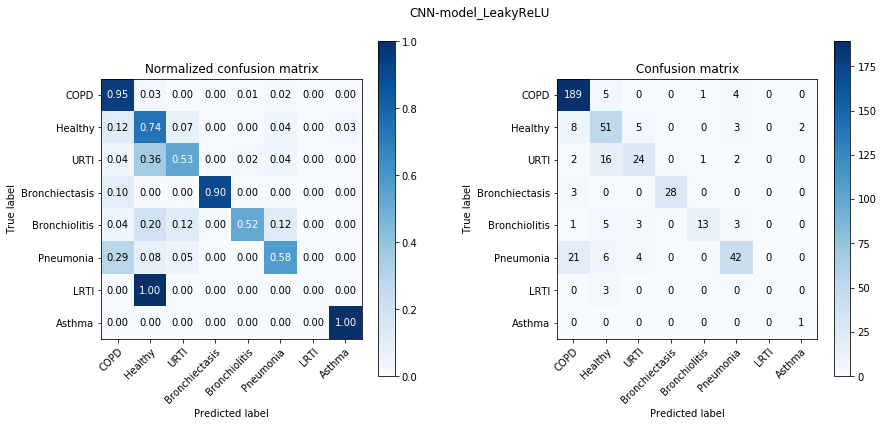

In [183]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(conf_matlr.numpy(), 
                      classes=diagnosisList, 
                      title=cnn_model_LR._name)


## CNN with LeakyReLU and no dropout

In [184]:
cnn_model_LR_noDrop = Sequential()
cnn_model_LR_noDrop._name = "CNN-model_LeakyReLU_NoDropOut"

cnn_model_LR_noDrop.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(128,40,1),padding='same'))
cnn_model_LR_noDrop.add(LeakyReLU(alpha=0.1))
cnn_model_LR_noDrop.add(MaxPooling2D((2, 2),padding='same'))
#cnn_model_LR.add(Dropout(0.1))
cnn_model_LR_noDrop.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
cnn_model_LR_noDrop.add(LeakyReLU(alpha=0.1))
cnn_model_LR_noDrop.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#cnn_model_LR.add(Dropout(0.1))
cnn_model_LR_noDrop.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
cnn_model_LR_noDrop.add(LeakyReLU(alpha=0.1))                  
cnn_model_LR_noDrop.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#cnn_model_LR.add(Dropout(0.1))
cnn_model_LR_noDrop.add(Flatten())
cnn_model_LR_noDrop.add(Dense(128, activation='linear'))
cnn_model_LR_noDrop.add(LeakyReLU(alpha=0.1))                  
cnn_model_LR_noDrop.add(Dense(num_labels, activation='softmax'))


In [185]:
cnn_model_LR_noDrop.summary()

Model: "CNN-model_LeakyReLU_NoDropOut"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 40, 32)       320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 40, 32)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 20, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 20, 64)        18496     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 20, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 10, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3

In [186]:
cnn_model_LR_noDrop.compile(loss=[tf.keras.losses.CategoricalCrossentropy()], 
              metrics=[tf.keras.metrics.CategoricalAccuracy()], 
              optimizer='adam')

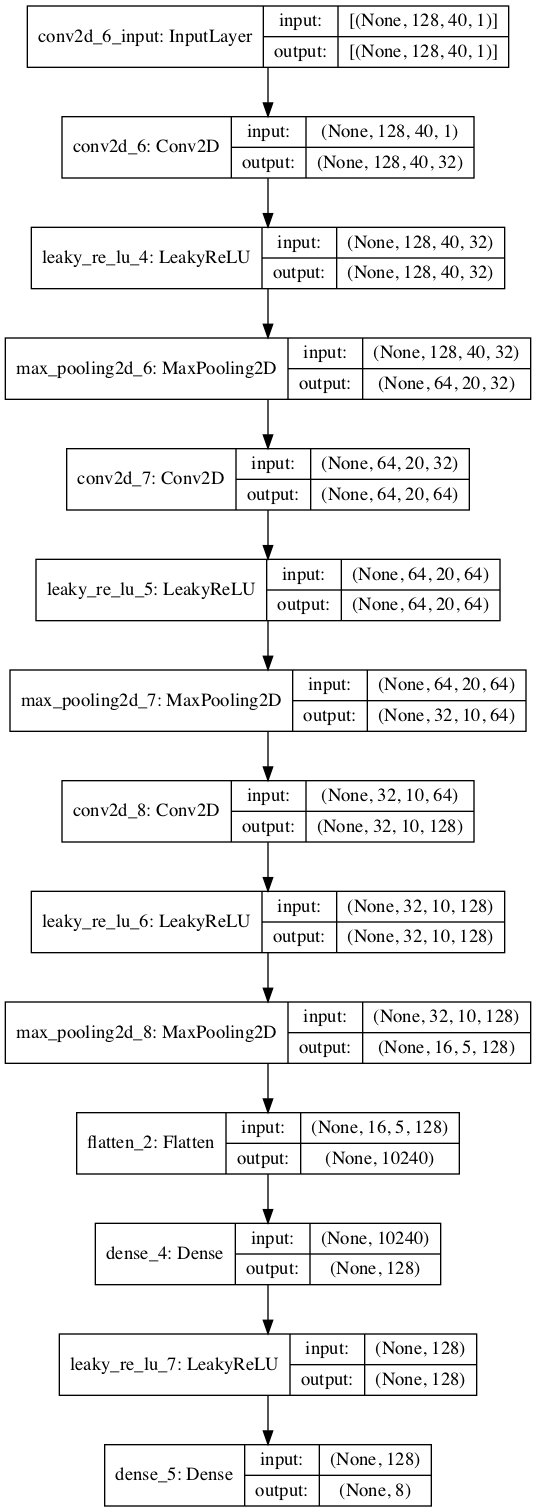

In [187]:
from tensorflow.keras import utils
utils.plot_model(cnn_model_LR_noDrop, 'BNA_Capstone_CNN-model_LeakyReLU_noDrop.png', show_shapes=True)

In [188]:
cnnlr_noDrop_history = cnn_model_LR_noDrop.fit(mfcc_train, y_train, batch_size=128, epochs=15, callbacks=callbacks, validation_data=(mfcc_val, y_val))

Train on 6313 samples, validate on 1487 samples
Epoch 1/15
6313/6313 [==============================] - 31s 5ms/sample - loss: 3.5008 - categorical_accuracy: 0.4225 - val_loss: 0.8365 - val_categorical_accuracy: 0.7236
Epoch 2/15
6313/6313 [==============================] - 29s 5ms/sample - loss: 0.5413 - categorical_accuracy: 0.8215 - val_loss: 0.3487 - val_categorical_accuracy: 0.8897
Epoch 3/15
6313/6313 [==============================] - 29s 5ms/sample - loss: 0.2914 - categorical_accuracy: 0.9051 - val_loss: 0.2319 - val_categorical_accuracy: 0.9233
Epoch 4/15
6313/6313 [==============================] - 29s 5ms/sample - loss: 0.1543 - categorical_accuracy: 0.9556 - val_loss: 0.1744 - val_categorical_accuracy: 0.9334
Epoch 5/15
6313/6313 [==============================] - 29s 5ms/sample - loss: 0.0751 - categorical_accuracy: 0.9829 - val_loss: 0.1171 - val_categorical_accuracy: 0.9670
Epoch 6/15
6313/6313 [==============================] - 30s 5ms/sample - loss: 0.0456 - categoric

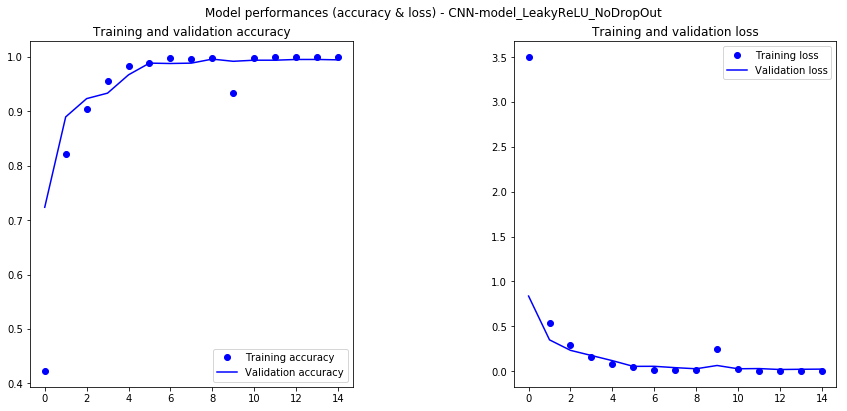

In [189]:
plot_model_perfos(cnn_model_LR_noDrop._name, cnnlr_noDrop_history)

In [190]:
train_loss, train_acc = cnn_model_LR_noDrop.evaluate(mfcc_train, y_train)

print('Train accuracy:', train_acc)
print('Train loss:', train_loss)

6313/6313 [==============================] - 12s 2ms/sample - loss: 6.4230e-04 - categorical_accuracy: 1.0000
Train accuracy: 1.0
Train loss: 0.0006422962924128549


In [191]:
val_loss, val_acc = cnn_model_LR_noDrop.evaluate(mfcc_val, y_val)

print('Val accuracy:', val_acc)
print('Val loss:', val_loss)

1487/1487 [==============================] - 3s 2ms/sample - loss: 0.0227 - categorical_accuracy: 0.9946
Val accuracy: 0.99462
Val loss: 0.022714077522850575


In [192]:
cnnlr_noDrop_predictions = cnn_model_LR_noDrop.predict(mfcc_test)

In [193]:
test_loss, test_acc = cnn_model_LR_noDrop.evaluate(mfcc_test, y_test)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

446/446 [==============================] - 1s 2ms/sample - loss: 0.7287 - categorical_accuracy: 0.8430
Test accuracy: 0.84304935
Test loss: 0.728659243861656


In [194]:
from sklearn.metrics import classification_report
report = classification_report(y_test.argmax(axis=1), 
                               cnnlr_noDrop_predictions.argmax(axis=1),
                              target_names=diagnosisList)
print(report)

                precision    recall  f1-score   support

          COPD       0.94      0.92      0.93       199
       Healthy       0.74      0.80      0.77        69
          URTI       0.64      0.67      0.65        45
Bronchiectasis       0.94      1.00      0.97        31
 Bronchiolitis       0.70      0.56      0.62        25
     Pneumonia       0.81      0.84      0.82        73
          LRTI       0.00      0.00      0.00         3
        Asthma       1.00      1.00      1.00         1

   avg / total       0.84      0.84      0.84       446



/Users/famillenassivet/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [195]:
conf_matlr_noDrop = tf.math.confusion_matrix(labels=y_test.argmax(axis=1), 
                         predictions=cnnlr_noDrop_predictions.argmax(axis=1))

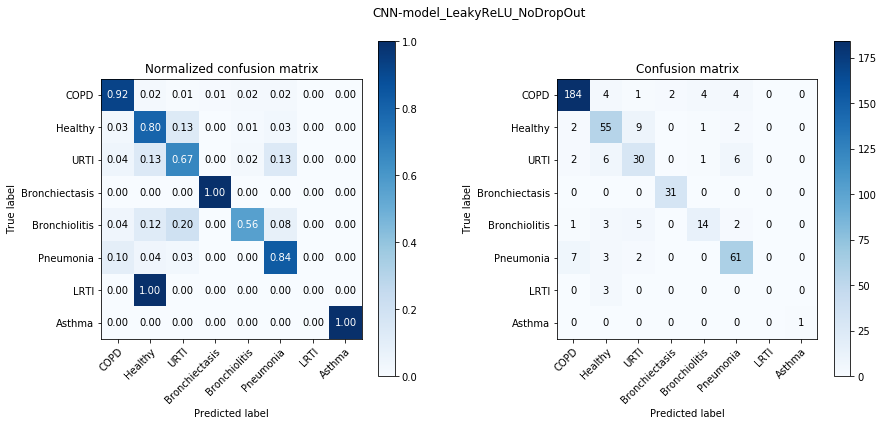

In [196]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(conf_matlr_noDrop.numpy(), 
                      classes=diagnosisList, 
                      title=cnn_model_LR_noDrop._name)


## Saving models

In [197]:
def save_model (nn_model, model_name=None):
    """
    serialize model to JSON
    """
    import os 
    model_path="./export_models/"
    
    if not os.path.exists(model_path): 
        os.makedirs(model_path) 
    if model_name is None:
        model_name = nn_model._name

    model_json = nn_model.to_json()
    
    with open(model_path+model_name +".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    nn_model.save_weights(model_path+model_name +".h5")
    print("Saved model" + model_name + " to disk")

In [198]:
save_model(model)

Saved modelDFF-NN_dense_2048_Drop0.2_dense_512_drop0.5 to disk


In [199]:
save_model(cnn_model)

Saved modelCNN-model to disk


In [200]:
save_model(cnn_model_LR)

Saved modelCNN-model_LeakyReLU to disk


In [201]:
save_model(cnn_model_LR_noDrop)

Saved modelCNN-model_LeakyReLU_NoDropOut to disk


In [202]:
plt.close()

In [203]:
#sc.stop()